In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import os
from scipy import stats
from edfreader import read_edf

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='enregistrement' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'parametre/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [5]:
timeStr = {}
timeStr['AM'] = '2017-10-23_100057'
timeStr['BMC'] = '2017-09-26_095637'
timeStr['CS'] = '2017-10-03_134421'
timeStr['DC']= '2017-09-27_161040'
timeStr['FM'] = '2017-10-03_143803'
timeStr['IP'] = '2017-09-28_115250'
timeStr['LB'] = '2017-09-20_151043'
timeStr['OP'] = '2017-10-26_121823'
timeStr['RS'] = '2017-11-08_094717'
timeStr['SR'] = '2017-11-16_153313'
timeStr['TN'] = '2017-11-08_150410'
timeStr['YK'] = '2017-11-17_172706'

# P_reel

In [6]:
p = exp[0]['p']

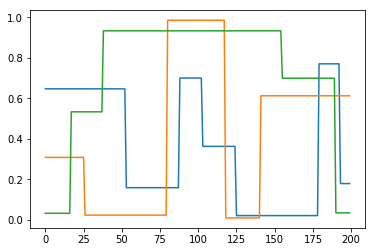

In [7]:
plt.plot(p[:, :, 1])
plt.show()

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice


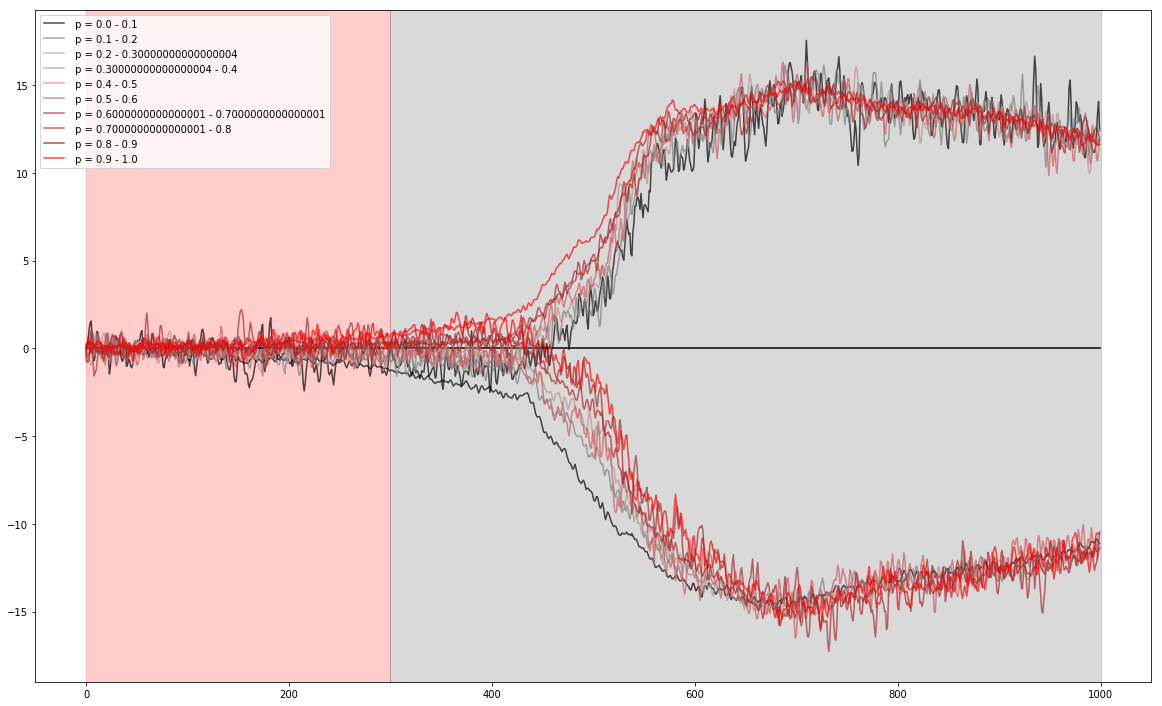

In [8]:
delta = 0.1
color = ['black','grey','darkgrey','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
PROBA = np.arange(0,1,delta)

va_r = {}
va_l = {}
mean_va_r = {}
mean_va_l = {}

for p_r in PROBA :
    va_r[p_r] = []
    va_l[p_r] = []
    mean_va_r[p_r] = []
    mean_va_l[p_r] = []

for x in range(len(exp)) :
    
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    v_anti = param[x]['v_anti']
    p = exp[x]['p']
    sujet = exp[x]['observer'] # sujet

    resultats = os.path.join('..','data', 'enregistrement_' + sujet + '_' + timeStr[sujet] + '.asc')
    data = read_edf(resultats, 'TRIALID')
    
    for block in range(N_blocks) :
        for trial in range(N_trials) :                
            trial_data = trial + N_trials*block
            data_x = data[trial_data]['x']
            trackertime = data[trial_data]['trackertime']
            
            StimulusOf = data[trial_data]['events']['msg'][14][0]
            #TargetOn = data[trial_data]['events']['msg'][15][0]
            TargetOff = data[trial_data]['events']['msg'][16][0]
            saccades = data[trial_data]['events']['Esac']
            trackertime_0 = data[trial_data]['trackertime'][0]

            gradient_x = np.gradient(data_x) # gradient en px/ms
            gradient_deg = gradient_x * 1/exp[x]['px_per_deg'] * 1000 # gradient en deg/sec

            ##################################################
            # SUPPRESSION DES SACCADES
            ##################################################
            gradient_deg_NAN = gradient_deg

            for s in range(len(saccades)) :
                if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
                        gradient_deg_NAN[x_data] = np.nan
                else :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
                        gradient_deg_NAN[x_data] = np.nan
            ##################################################
            bino=p[trial, block, 0]
            p_reel = p[trial, block, 1]
            
            for p_r in PROBA :
                if p_reel >= p_r and p_reel < (p_r + delta) :
                    if bino == 0 : # droite c'est 1 gauche c'est 0
                        va_l[p_r].append(gradient_deg_NAN[StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])
                    elif bino == 1 :
                        va_r[p_r].append(gradient_deg_NAN[StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])


fig_width = 20
fig, axs = plt.subplots(1, 1, figsize=(fig_width, 1*fig_width/(1.6180*1)))
axs.plot(np.zeros(1000), c='k')            
x=0                      
for p_r in PROBA :
    for tps in range(1000) :
        liste_r = []
        for a in range(len(va_r[p_r])) :
            liste_r.append(va_r[p_r][a][tps])
        mean_va_r[p_r].append(np.nanmean(liste_r))

        liste_l = []
        for b in range(len(va_l[p_r])) :
            liste_l.append(va_l[p_r][b][tps])
        mean_va_l[p_r].append(np.nanmean(liste_l))
        
    axs.plot(mean_va_r[p_r], c=color[x], label=' p = %s - %s'%(p_r, p_r+delta), alpha=0.7)
    axs.plot(mean_va_l[p_r], c=color[x], alpha=0.7)
    x=x+1 

axs.axvspan(0, 300, color='r', alpha=0.2)
axs.axvspan(300, 1000, color='k', alpha=0.15)
plt.legend()
plt.show()

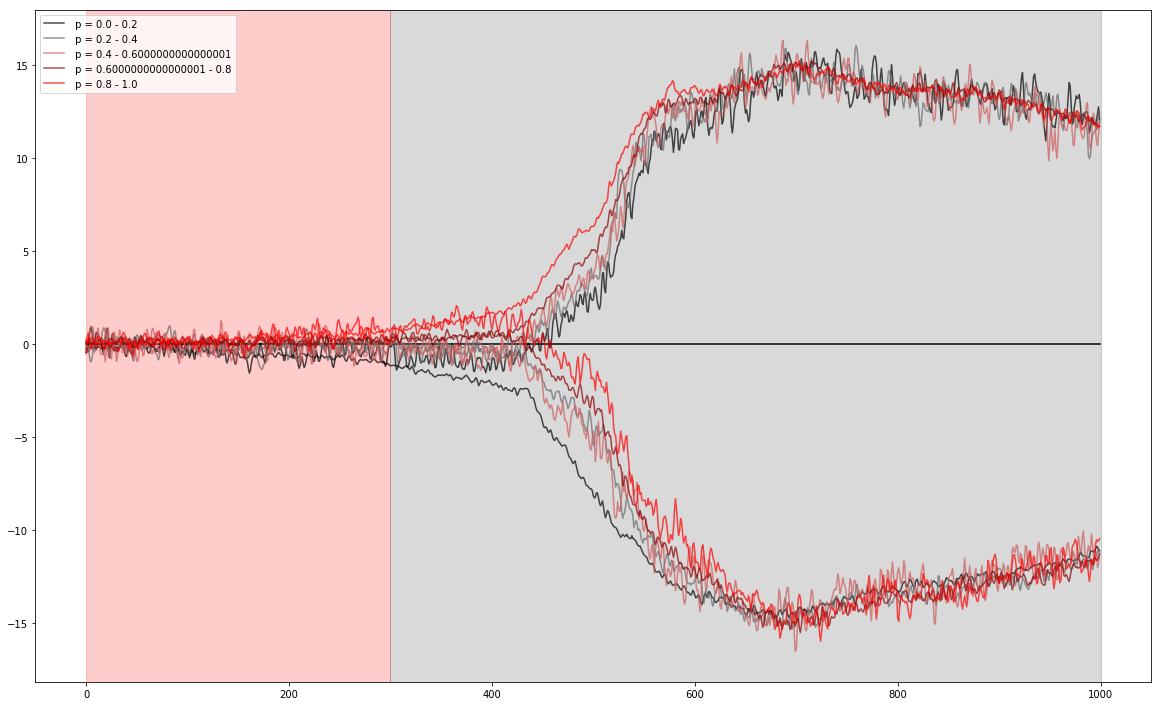

In [9]:
delta = 0.2
color = ['black','dimgrey','indianred','darkred','red']
PROBA = np.arange(0,1,delta)

va_r = {}
va_l = {}
mean_va_r = {}
mean_va_l = {}

for p_r in PROBA :
    va_r[p_r] = []
    va_l[p_r] = []
    mean_va_r[p_r] = []
    mean_va_l[p_r] = []

for x in range(len(exp)) :
    
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    v_anti = param[x]['v_anti']
    p = exp[x]['p']
    sujet = exp[x]['observer'] # sujet

    resultats = os.path.join('..','data', 'enregistrement_' + sujet + '_' + timeStr[sujet] + '.asc')
    data = read_edf(resultats, 'TRIALID')
    
    for block in range(N_blocks) :
        for trial in range(N_trials) :                
            trial_data = trial + N_trials*block
            data_x = data[trial_data]['x']
            trackertime = data[trial_data]['trackertime']
            
            StimulusOf = data[trial_data]['events']['msg'][14][0]
            #TargetOn = data[trial_data]['events']['msg'][15][0]
            TargetOff = data[trial_data]['events']['msg'][16][0]
            saccades = data[trial_data]['events']['Esac']
            trackertime_0 = data[trial_data]['trackertime'][0]

            gradient_x = np.gradient(data_x) # gradient en px/ms
            gradient_deg = gradient_x * 1/exp[x]['px_per_deg'] * 1000 # gradient en deg/sec

            ##################################################
            # SUPPRESSION DES SACCADES
            ##################################################
            gradient_deg_NAN = gradient_deg

            for s in range(len(saccades)) :
                if saccades[s][1]-trackertime_0+15 <= (len(trackertime)) :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (saccades[s][1]-trackertime_0+15)) :
                        gradient_deg_NAN[x_data] = np.nan
                else :
                    for x_data in np.arange((saccades[s][0]-trackertime_0-5), (len(trackertime))) :
                        gradient_deg_NAN[x_data] = np.nan
            ##################################################
            bino=p[trial, block, 0]
            p_reel = p[trial, block, 1]
            
            for p_r in PROBA :
                if p_reel >= p_r and p_reel < (p_r + delta) :
                    if bino == 0 : # droite c'est 1 gauche c'est 0
                        va_l[p_r].append(gradient_deg_NAN[StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])
                    elif bino == 1 :
                        va_r[p_r].append(gradient_deg_NAN[StimulusOf-trackertime_0:StimulusOf-trackertime_0+1300])

                        
fig_width = 20
fig, axs = plt.subplots(1, 1, figsize=(fig_width, 1*fig_width/(1.6180*1)))
axs.plot(np.zeros(1000), c='k')            
x=0                      
for p_r in PROBA :
    for tps in range(1000) :
        liste_r = []
        for a in range(len(va_r[p_r])) :
            liste_r.append(va_r[p_r][a][tps])
        mean_va_r[p_r].append(np.nanmean(liste_r))

        liste_l = []
        for b in range(len(va_l[p_r])) :
            liste_l.append(va_l[p_r][b][tps])
        mean_va_l[p_r].append(np.nanmean(liste_l))
        
    axs.plot(mean_va_r[p_r], c=color[x], label=' p = %s - %s'%(p_r, p_r+delta), alpha=0.7)
    axs.plot(mean_va_l[p_r], c=color[x], alpha=0.7)
    x=x+1 

axs.axvspan(0, 300, color='r', alpha=0.2)
axs.axvspan(300, 1000, color='k', alpha=0.15)
plt.legend()
plt.show()